# MicaSense RedEdge Image Processing Tutorial 1

## Overview

This tutorial assumes you have gone through the basic setup [here](./MicaSense Image Processing Setup.html) and your system is set up and ready to go.

In this tutorial, we will walk through how to convert RedEdge data from raw images to radiace and then to reflectance. We will cover the tools required to do this, and walk through some of the basic image processing and radiometric conversions. 

### Opening an image with pyplot

RedEdge 16-bit images can be read with pyplot directly into numpy arrays using the pyplot `imread` function or the matplotlib `imread` function, and then we can display the image inline using the `imshow` function of `matplotlib`.


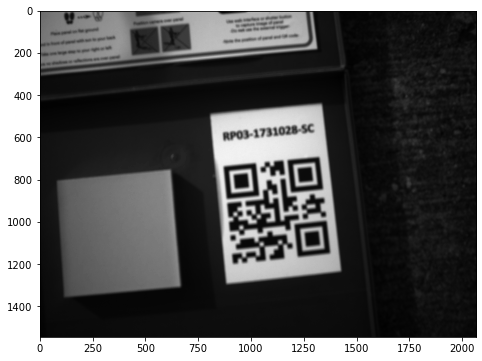

In [24]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os,glob
import math
%matplotlib inline

#imagePath = os.path.join('.','data','0000SET','000')
imagePath = r"\\PNL\Projects\UAV_Imagery\aafcam\20211113a\0000SET\000"
imageName = os.path.join(imagePath,'IMG_0000_1.tif')

# Read raw image DN values
# reads 16 bit tif - this will likely not work for 12 bit images
imageRaw=plt.imread(imageName)

# Display the image
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(imageRaw, cmap='gray')
plt.show()

### MicaSense Utilities Module

For many of the steps in the tutorial, we will use code from the MicaSense utilities module.  The code is in the micasense directory and can be imported via normal python import commands using the syntax `import micasense` or `import micasense.submodule as short_name` for use in this and other scripts. While we will not cover all of the utility functions in this tutorial, they are available for reference and some will be used and discussed in future tutorials.

### Adding a colorbar

We will use start by using a plotting function in `micasense.plotutils` that adds a colorbar to the display, so that we can more easily see changes in the values in the images and also see the range of the image values after various conversions.  This function also colorizes the grayscale images, so that changes can more easily be seen.  Depending on your viewing style, you may prefer a different color map and you can also select that colormap here or browsing the colormaps on the [matplotlib site](https://matplotlib.org/users/colormaps.html). 

<Figure size 432x288 with 0 Axes>

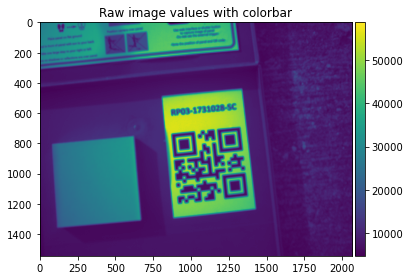

In [25]:
import micasense.plotutils as plotutils

# Optional: pick a color map that fits your viewing style
# one of 'gray, viridis, plasma, inferno, magma, nipy_spectral'
plotutils.colormap('viridis'); 

fig = plotutils.plotwithcolorbar(imageRaw, title='Raw image values with colorbar')

### Reading RedEdge Metadata

In order to perform various processing on the images, we need to read the metadata of each image.  For this we use ExifTool. We can read standard image capture metadata such as location, UTC time, imager exposure and gain, but also RedEdge specific metadata which can make processing workflows easier.  

For example, each image contains a  unique capture identifier.  Capture identifiers are shared between all 5 images captured by RedEdge at the same moment, and can be used to unambiguously group images in post processing, regardless of how the images are named or stored on disk.  Each image also contains a flight identifer which is the same for all images taken during a single power cycle of the camera.  This can be used in post-processing workflows to group images and in many cases, more easily identify when the vehicle took off and landed.

In [26]:
import micasense.metadata as metadata
exiftoolPath = None
if os.name == 'nt':
    exiftoolPath = os.environ.get('exiftoolpath')
# get image metadata
meta = metadata.Metadata(imageName, exiftoolPath=exiftoolPath)
cameraMake = meta.get_item('EXIF:Make')
cameraModel = meta.get_item('EXIF:Model')
firmwareVersion = meta.get_item('EXIF:Software')
bandName = meta.get_item('XMP:BandName')
print('{0} {1} firmware version: {2}'.format(cameraMake, 
                                             cameraModel, 
                                             firmwareVersion))
print('Exposure Time: {0} seconds'.format(meta.get_item('EXIF:ExposureTime')))
print('Imager Gain: {0}'.format(meta.get_item('EXIF:ISOSpeed')/100.0))
print('Size: {0}x{1} pixels'.format(meta.get_item('EXIF:ImageWidth'),meta.get_item('EXIF:ImageHeight')))
print('Band Name: {0}'.format(bandName))
print('Center Wavelength: {0} nm'.format(meta.get_item('XMP:CentralWavelength')))
print('Bandwidth: {0} nm'.format(meta.get_item('XMP:WavelengthFWHM')))
print('Capture ID: {0}'.format(meta.get_item('XMP:CaptureId')))
print('Flight ID: {0}'.format(meta.get_item('XMP:FlightId')))
print('Focal Length: {0}'.format(meta.get_item('XMP:FocalLength')))

MicaSense Altum firmware version: v2.3.2
Exposure Time: 0.001695028 seconds
Imager Gain: 2.0
Size: 2064x1544 pixels
Band Name: Blue
Center Wavelength: 475 nm
Bandwidth: 20 nm
Capture ID: HCK3JegyMJDrl2Vwjwbo
Flight ID: qcDVnKInfQTdUOMGZJj9
Focal Length: None


### Converting raw images to Radiance

Ultimately most RedEdge users want to calibrate raw images from the camera into reflectance maps.  This can be done using off-the-shelf software from third parties, but you are here because there is no fun in that!  Along with this tutorial we have included some helper utilities that will handle much of this conversion for you, but here we will walk through a few of those functions to discuss what is happening inside.

Any RedEdge workflow must include these common steps.
1. Un-bias images by accounting for the dark pixel offset
1. Compensate for imager-level effects
1. Compensate for optical chain effects
1. Normalize images by exposure and gain settings
1. Convert to a common unit system (radiance)

All of these are handled by the `micasense.utils.raw_image_to_radiance(metadata, raw_image)` function.  Let us take a look at that fuction in more detail.

First, we get the darkPixel values. These values come from optically-covered pixels on the imager which are exposed at the same time as the image pixels. They measure the small amount of random charge generation in each pixel, independent of incoming light, which is common to all semiconductor imaging devices.
```python
    blackLevel = np.array(meta.get_item('Exif.BlackLevel'))
    darkLevel = blackLevel.mean()
```
Now, we get the imager-specific calibrations.
```python
    a1, a2, a3 = meta.get_item('XMP:RadiometricCalibration')
```
We get the parameters of the optical chain (vignette) effects and create a vignette map. This map will be multiplied by the black-level corrected image values to reverse the darkening seen at the image corners.  See the `vignette_map` function for the details of the vignette parameters and their use.
```python
    V, x, y = vignette_map(meta, xDim, yDim)
```
Now we can calculate the imager-specfic radiometric correction function, which help to account for the radiometric inaccuracies of the CMOS imager pixels.
```python
    # row gradient correction
    R = 1.0 / (1.0 + a2 * y / exposureTime - a3 * y)
```
Finally, we apply these functions to the raw image to result in a corrected image
```python
    # subtract the dark level and adjust for vignette and row gradient
    L = V * R * (imageRaw - darkLevel)
```
Next, we get the exposure and gain settings (gain is represented in the photographic parameter ISO, with a base ISO of 100, so we divide the result to get a numeric gain).
```python
    exposureTime = float(meta.get_item('EXIF:ExposureTime'))
    gain = float(meta.get_item('EXIF:ISOSpeed'))/100.0 
```
Now that we have a corrected image, we can apply a conversion from calibrated digital number values to radiance units (W/m^2/nm/sr). Note that in this conversion, we need to normalize by the image bitdepth (2^16 for 16 bit images, 2^12 for 12-bit images), because the calibration coefficients are scaled to work with normalized input values.
```python
    # apply the radiometric calibration - 
    # scale by the gain-exposure product and multiply with the radiometric calibration coefficient
    bitsPerPixel = meta.get_item('EXIF:BitsPerSample')
    dnMax = float(2**bitsPerPixel)
    radianceImage = L.astype(float)/(gain * exposureTime)*a1/dnMax
 ```
 
For convenience, we have written the `raw_image_to_radiance` function to return the intermediate compensation images as well, so we can visualize them for the tutorial. These intermediate results are not required in most implementations and can be ommitted, if performance is a concern.

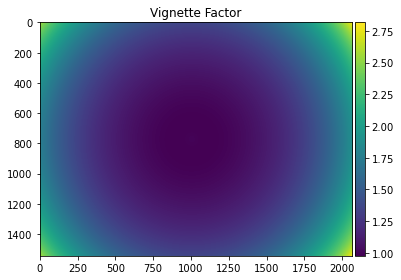

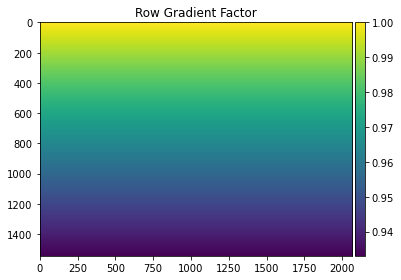

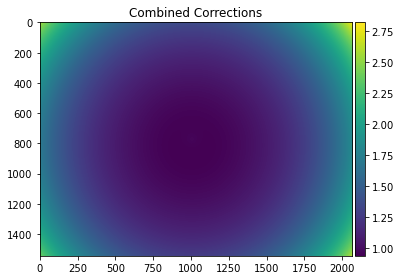

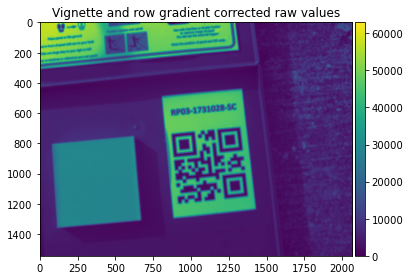

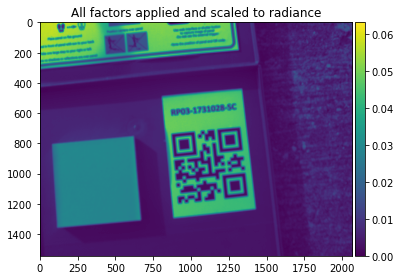

In [27]:
import micasense.utils as msutils
radianceImage, L, V, R = msutils.raw_image_to_radiance(meta, imageRaw)
plotutils.plotwithcolorbar(V,'Vignette Factor');
plotutils.plotwithcolorbar(R,'Row Gradient Factor');
plotutils.plotwithcolorbar(V*R,'Combined Corrections');
plotutils.plotwithcolorbar(L,'Vignette and row gradient corrected raw values');
plotutils.plotwithcolorbar(radianceImage,'All factors applied and scaled to radiance');

### Convert radiance to reflectance

Now that we have a flat and calibrated radiance image, we can convert into reflectance.  To do this, we will use the radiance values of the panel image of known reflectance to determine a scale factor between radiance and reflectance.

In this case, we have our MicaSense calibrated reflectance panel and it's known reflectance of 62% in the band of interest.  We will extract the area of the image containing the lambertian panel, determine it's radiance to reflectance scale factor, and then scale the whole image by that factor to get a reflectance image.

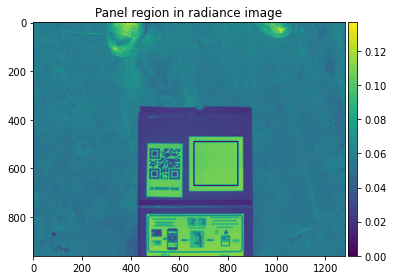

Mean Radiance in panel region: 0.107 W/m^2/nm/sr
Radiance to reflectance conversion factor: 5.727


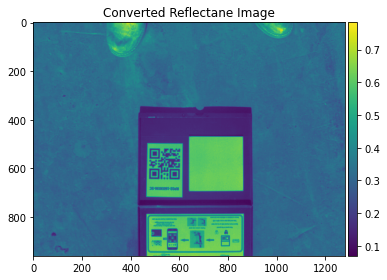

In [18]:
markedImg = radianceImage.copy()
ulx = 660 # upper left column (x coordinate) of panel area
uly = 490 # upper left row (y coordinate) of panel area
lrx = 840 # lower right column (x coordinate) of panel area
lry = 670 # lower right row (y coordinate) of panel area
cv2.rectangle(markedImg,(ulx,uly),(lrx,lry),(0,255,0),3)

# Our panel calibration by band (from MicaSense for our specific panel)
panelCalibration = { 
    "Blue": 0.67, 
    "Green": 0.69, 
    "Red": 0.68, 
    "Red edge": 0.67, 
    "NIR": 0.61 
}

# Select panel region from radiance image
panelRegion = radianceImage[uly:lry, ulx:lrx]
plotutils.plotwithcolorbar(markedImg, 'Panel region in radiance image')
meanRadiance = panelRegion.mean()
print('Mean Radiance in panel region: {:1.3f} W/m^2/nm/sr'.format(meanRadiance))
panelReflectance = panelCalibration[bandName]
radianceToReflectance = panelReflectance / meanRadiance
print('Radiance to reflectance conversion factor: {:1.3f}'.format(radianceToReflectance))

reflectanceImage = radianceImage * radianceToReflectance
plotutils.plotwithcolorbar(reflectanceImage, 'Converted Reflectane Image');

In some cases we might notice that some parts of a converted reflectance image show reflectances above 1.0, or 100%, and wonder how this is possible.  In fact, reflectances higher than 100% are normal in specific cases of [specular reflections](https://en.wikipedia.org/wiki/Specular_reflection). The panel area is a special material that reflects incident light equally well in all directions; however, some of the objects in a scene (especially man-made objects) instead reflect most incident light in one direction, more like a mirror.  An example is the reflection of the sun off of the smooth surface of a car or the reflection off of a body of water.


Now we will extract the same region and verify the reflectance in that region is what we expect. In the process, we will blur and visualize the extracted area to look for any trends.  The area should have a very consistent reflectance. If a gradient or a high standard deviation (>3% absolute reflectance) is noticed across the panel area it is possible that the panel was captured under inconsistent lighting conditions (e.g. next to a wall or vehicle) or it was captured too close to the edge of the image where the optical calibration is the least accurate.

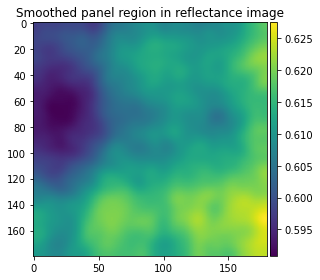

Min Reflectance in panel region: 0.56
Max Reflectance in panel region: 0.68
Mean Reflectance in panel region: 0.61
Standard deviation in region: 0.0135


In [19]:
panelRegionRaw = imageRaw[uly:lry, ulx:lrx]
panelRegionRefl = reflectanceImage[uly:lry, ulx:lrx]
panelRegionReflBlur = cv2.GaussianBlur(panelRegionRefl,(55,55),5)
plotutils.plotwithcolorbar(panelRegionReflBlur, 'Smoothed panel region in reflectance image')
print('Min Reflectance in panel region: {:1.2f}'.format(panelRegionRefl.min()))
print('Max Reflectance in panel region: {:1.2f}'.format(panelRegionRefl.max()))
print('Mean Reflectance in panel region: {:1.2f}'.format(panelRegionRefl.mean()))
print('Standard deviation in region: {:1.4f}'.format(panelRegionRefl.std()))

In this case the panel is less uniform than we would like, but we can also notice that the full color scale is only 4% of absolute reflectance.  Likewise, it's well below the standard deviation threshold we have set of 3% absolute reflectance. This panel has seen over two years of hard field use, so it may be time for it to retire.  

Reasons for a high standard deviation across a panel can include panel contamination or inconsistent lighting across the panel due to environmental conditions.  Based on the context of the image, it is also clear that the user is taking the panel image facing the sun, which can cast reflected light from the operator's clothing on the panel and contaminate results. For this reason it is always best to capture panel images in an open area and with the operator's back to the sun. 

### Undistorting images

Finally, we need to remove lens distortion effects from images for some processing workflows, such as band-to-band image alignment.  Generally for photogrammetry processes on raw (or radiance/reflectance) images, this step is not required, as the photogrammetry process will optimize a lens distortion model as part of it's bulk bundle adjustment.  RedEdge has very low distortion lenses, so the changes to images in this step tend to be very small and noticeable only in pixels on the border of the image.

In [ ]:
# correct for lens distortions to make straight lines straight
undistortedReflectance = msutils.correct_lens_distortion(meta, reflectanceImage)
plotutils.plotwithcolorbar(undistortedReflectance, 'Undistorted reflectance image');

# In Practice

Now that we can convert from raw RedEge images to reflectance, we will use these methods to convert an image taken during the same campaign to a reflectance image, and look at a few interesting areas of the image to validate our conversion.

In [ ]:
flightImageName = os.path.join(imagePath,'IMG_0001_4.tif')
flightImageRaw=plt.imread(flightImageName)
plotutils.plotwithcolorbar(flightImageRaw, 'Raw Image')

flightRadianceImage, _, _, _ = msutils.raw_image_to_radiance(meta, flightImageRaw)
flightReflectanceImage = flightRadianceImage * radianceToReflectance
flightUndistortedReflectance = msutils.correct_lens_distortion(meta, flightReflectanceImage)
plotutils.plotwithcolorbar(flightUndistortedReflectance, 'Reflectance converted and undistorted image');

# Conclusion

In this tutorial we have found that we can read MicaSense RedEdge images and their metadata, and use python and OpenCV to convert those images to radiance and then to reflectance using the standard scientific field method of imaging a lambertian reflector.  We have corrected for both the electro-optical effects of the sensor and optical chain, as well as the incident light at the time of capture.

In future tutorials, we will introduce the Downwelling Light Sensor (DLS) information into the calibration process in order to account for changing irradiance over time (e.g. such as clouds).  However, since the panel method is straightforward and repeatable under constant illumination conditions, and is the standard scientific calibration method of surface reflectance, this  process is useful and sufficient for many calibration needs.

Looking for more? Try the second tutorial [here](./MicaSense%20Image%20Processing%20Tutorial%202.html).

---
Copyright (c) 2017-2019 MicaSense, Inc.  For licensing information see the [project git repository](https://github.com/micasense/imageprocessing)